## I imported all the necesary data and downloaded a file of profit data for movies 

In [1457]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import json
import sqlite3
import numpy as np
%matplotlib inline
from PIL import Image
import seaborn as sns

thenums_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')


## I made a function that turned object columns into integer colums ###

I ran this function onto the columns of this dataframe


In [1458]:
# This function turns series columns into integers
def make_column_integer(df, series):
    df[series] = df[series].str.replace('$', '')
    df[series] = df[series].str.replace(',', '')
    df[series] = df[series].astype(int)

# Turns all the columns in this dataframe into integers
make_column_integer(thenums_df, 'production_budget')
make_column_integer(thenums_df, 'domestic_gross')
make_column_integer(thenums_df, 'worldwide_gross')


## I then made 2 new columns: 

One column called "total_gross" which was the sum of the domestic and worldwide grossings, and another column called "total_profit" that is the total gross minus the production cost.



In [1459]:
thenums_df['total_profit'] = (thenums_df['worldwide_gross']-thenums_df['production_budget'])
thenums_df.sort_values('total_profit', ascending = False, inplace=True)

# I imported a new dataframe from the IMDB database that contained the genres of the movies.

In [1460]:
imdb_title_basics = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')



# I merged the profits dataframe and the title basics dataframe



In [1461]:
master_movies_df = pd.merge(imdb_title_basics, thenums_df, how='inner', left_on='primary_title', right_on='movie')

In [1462]:
# Sorted the values by hightest profit
master_movies_df = master_movies_df.sort_values('total_profit', ascending=False)

In [1463]:
# Drops redundant columns
master_movies_df = master_movies_df.drop(columns = ['original_title', 'start_year', 'id', 'movie'])

In [1464]:
# Drops the duplicated movies from the dataframe
master_movies_df = master_movies_df.drop_duplicates(subset='primary_title')

In [1465]:
#Sets the index to their tconst
master_movies_df.set_index('tconst', inplace=True)

In [1466]:
#Drops all null values from the genres catagory
master_movies_df.dropna(subset=['genres'], inplace=True)

In [1467]:
master_movies_df.at['tt1775309', 'genres'] = 'Action,Adventure,Fantasy'

# This saves the master_movies_df DataFrame into a CSV File

In [1468]:
master_movies_df.to_csv('master_movie_database')
pd.read_csv('master_movie_database')

,tconst,primary_title,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,total_profit
0,tt1775309,Avatar,93.0,"Action,Adventure,Fantasy","Dec 18, 2009",425000000,760507625,2776345279,2351345279
1,tt8852130,Titanic,115.0,Family,"Dec 19, 1997",200000000,659363944,2208208395,2008208395
2,tt4154756,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi","Apr 27, 2018",300000000,678815482,2048134200,1748134200
3,tt0369610,Jurassic World,124.0,"Action,Adventure,Sci-Fi","Jun 12, 2015",215000000,652270625,1648854864,1433854864
4,tt2820852,Furious 7,137.0,"Action,Crime,Thriller","Apr 3, 2015",190000000,353007020,1518722794,1328722794
...,...,...,...,...,...,...,...,...,...
2282,tt7504726,Call of the Wild,NaN,"Adventure,Animation,Family","Feb 21, 2020",82000000,0,0,-82000000
2283,tt5519340,Bright,117.0,"Action,Crime,Fantasy","Dec 13, 2017",90000000,0,0,-90000000
2284,tt2283336,Men in Black: International,115.0,"Action,Adventure,Comedy","Jun 14, 2019",110000000,3100000,3100000,-106900000
2285,tt1305591,Mars Needs Moms,88.0,"Adventure,Animation,Family","Mar 11, 2011",150000000,21392758,39549758,-110450242


# I made a list of all possible genres for each movie

In [1469]:
# Puts all the genres for each movie into a list
list_of_genres = master_movies_df['genres']
list_of_genres = list_of_genres.str.split(',')

In [1470]:
nunique_genres=[]
for x in list_of_genres:
    for genre in x:
        nunique_genres.append(genre)

unique_genres = set(nunique_genres)

## I cleaned up and seperated the total movie database
### I moved all the movies with no gross earnings into a database called "stream_movies", and I took all the others and named the new database "theater_movies"

In [1474]:
stream_movies = master_movies_df.loc[master_movies_df['worldwide_gross']== 0]
stream_movies = stream_movies.sort_values(by='production_budget', ascending=False)
stream_movies = stream_movies.drop(['domestic_gross','worldwide_gross','total_profit'], axis='columns')

In [1476]:
theater_movies = master_movies_df[master_movies_df.worldwide_gross != 0]

## I made CSV files out of theater movies and streamed movies

In [1483]:
theater_movies.to_csv('all_theater_movies_df')
stream_movies.to_csv('all_streamed_movies_df')

# I then broke up the dataframe into sub-dataframes, for each genre we are analyzing.
#### I then broke up the genre dataframes into theatrical releases and streaming releases


In [1484]:
action_movies= theater_movies[theater_movies.genres.str.contains('Action' or 'Adventure')]
drama_movies= theater_movies[theater_movies.genres.str.contains('Drama')]
comedy_movies= theater_movies[theater_movies.genres.str.contains('Comedy')]
horror_movies= theater_movies[theater_movies.genres.str.contains('Horror')]

In [1485]:
action_movies_st= stream_movies[stream_movies.genres.str.contains('Action' or 'Adventure')]
drama_movies_st= stream_movies[stream_movies.genres.str.contains('Drama')]
comedy_movies_st= stream_movies[stream_movies.genres.str.contains('Comedy')]
horror_movies_st= stream_movies[stream_movies.genres.str.contains('Horror')]

## This Function turns the dataframes into CSV files

In [1486]:
def make_csv(data, file_name):
    filename = data.to_csv(file_name)
    return filename

# This WebScrapes the taglines from IMDb for each movie
### It then organizes the first five taglines into a list for each movie
#### It is commented out because you don't need to run it

In [1424]:
# def get_tags(data):
#     no_table = []
#     list_of_tags = []
#     for tconst in data.index:
#         url = f'https://www.imdb.com/title/{tconst}/keywords?ref_=tt_stry_kw'
#         response = requests.get(url)
#         soup = BeautifulSoup(response.text, 'lxml')
        
#         try:
#             table = soup.find_all('table', {'class': 'dataTable'})[0]
#             a_tags = [x.find('a') for x in table.find_all('td', {'class': 'soda sodavote'})]
#             if len([x.text for x in a_tags]) > 5:
#                 text = [x.text for x in a_tags][:5]
#             else:
#                 text = [x.text for x in a_tags]
        
#             list_of_tags.append(text)
        
#         except:
#             no_table.append(tconst)
#             list_of_tags.append([None])
  
#     return list_of_tags

### I ran this web scraping function on my 4 dataframes

In [969]:
# horror_tags = get_tags(horror_movies)

In [1453]:
# action_tags = get_tags(action_movies)

In [1454]:
# comedy_tags = get_tags(comedy_movies)

In [1455]:
# drama_tags = get_tags(drama_movies)

In [1495]:
# horror_movies['tags'] = horror_tags
# comedy_movies['tags'] = comedy_tags
# action_movies['tags'] = action_tags
# drama_movies['tags'] = drama_tags

In [1496]:
make_csv(action_movies, 'action_movies_df')
make_csv(comedy_movies, 'comedy_movies_df')
make_csv(drama_movies, 'drama_movies_df')
make_csv(horror_movies, 'horror_movies_df')

make_csv(action_movies_st, 'action_movies_st_df')
make_csv(comedy_movies_st, 'comedy_movies_st_df')
make_csv(drama_movies_st, 'drama_movies_st_df')
make_csv(horror_movies_st, 'horror_movies_st_df')

# This Function makes a string of all the titles for a Word Cloud

In [1693]:
def make_list_of_titles(df):
    list_of_titles = list(df['primary_title'])
    titlestring = ' '.join(list_of_titles)

In [1695]:
action_titles = make_list_of_titles(successful_action)
comedy_titles = make_list_of_titles(successful_comedy)
drama_titles = make_list_of_titles(successful_drama)
horror_titles = make_list_of_titles(successful_horror)

  
# A function that creates a new dataframe for each genre (where the profits for each movie are over $1,000,000)
 

In [1497]:
def get_successful(df):
    df_successes = df.loc[df['total_profit'] > 1000000]
    return df_successes

In [1498]:
successful_action = get_successful(action_movies)

In [1499]:
successful_comedy = get_successful(comedy_movies)

In [1500]:
successful_drama = get_successful(drama_movies)

In [1501]:
successful_horror = get_successful(horror_movies)

#### A funtion that spits out a dataframe for each genre of movie

In [1503]:
def get_genre_db(db, genre):
    return db[db["genres"].str.contains(genre)]

#### A function that gets the median value for profit earned for a given genre

In [1504]:
def get_median():
    list_of_med_nums= []
    for genre in unique_genres:
        list_of_med_nums.append(get_genre_db(master_movies_df, genre).describe()['total_profit']['50%'])
    #list_of_meds = list(zip(unique_genres,list_of_med_nums))
    return list_of_med_nums

# This Function removes the null values from the tag lists for each genre, and makes it into one list of all the tags

In [1639]:
def removenulls(tag_list):
    for x in tag_list:
        if None in x:
            tag_list.remove(x)
    return tag_list

In [1640]:
horror_tags_nonull = removenulls(horror_tags)
comedy_tags_nonull = removenulls(comedy_tags)
action_tags_nonull = removenulls(action_tags)
drama_tags_nonull = removenulls(drama_tags)

### Lists all tags in one list

In [1679]:
def list_all_tags(tag_list):
    all_tags = []
    for tags in tag_list:
        for tag in tags:
                all_tags.append(tag)
    return all_tags

# Those lists were transformed into strings for the Word Cloud

In [1680]:
all_horror_tags = list_all_tags(horror_tags_nonull)
all_drama_tags = list_all_tags(drama_tags_nonull)
all_comedy_tags = list_all_tags(comedy_tags_nonull)
all_action_tags = list_all_tags(action_tags_nonull)

In [1681]:
def tt(all_tags):
    for x in range(len(all_tags)):
        all_tags[x] = all_tags[x].title()
        all_tags[x] = all_tags[x].replace(' ','_')
    return ' '.join(all_tags)
     

In [1778]:
horror_tt = tt(all_horror_tags)
drama_tt = tt(all_drama_tags)
comedy_tt = tt(all_comedy_tags)
action_tt = tt(all_action_tags)

# This saved all the tags as text files so I don't have to rescrape every time

In [1782]:
file = open('horror_tags.txt', 'w')
file.write(horror_tt)
file.close()

file = open('drama_tags.txt', 'w')
file.write(drama_tt)
file.close()

file = open('comedy_tags.txt', 'w')
file.write(comedy_tt)
file.close()

file = open('action_tags.txt', 'w')
file.write(action_tt)
file.close()

# This reopens the tag files to continue using for the Word Clouds

In [2025]:
horror_tt = open('horror_tags.txt', 'r')
drama_tt = open('drama_tags.txt', 'r')
comedy_tt = open('comedy_tags.txt', 'r')
action_tt = open('action_tags.txt', 'r')

action_tt = action_tt.read()
drama_tt = drama_tt.read()
comedy_tt = comedy_tt.read()
horror_tt = horror_tt.read()

action_tt = action_tt.replace('Sequel', '')
comedy_tt = comedy_tt.replace('Sequel', '')

In [2027]:
'Sequel' in comedy_tt

False

# The World Cloud for each genre's tags

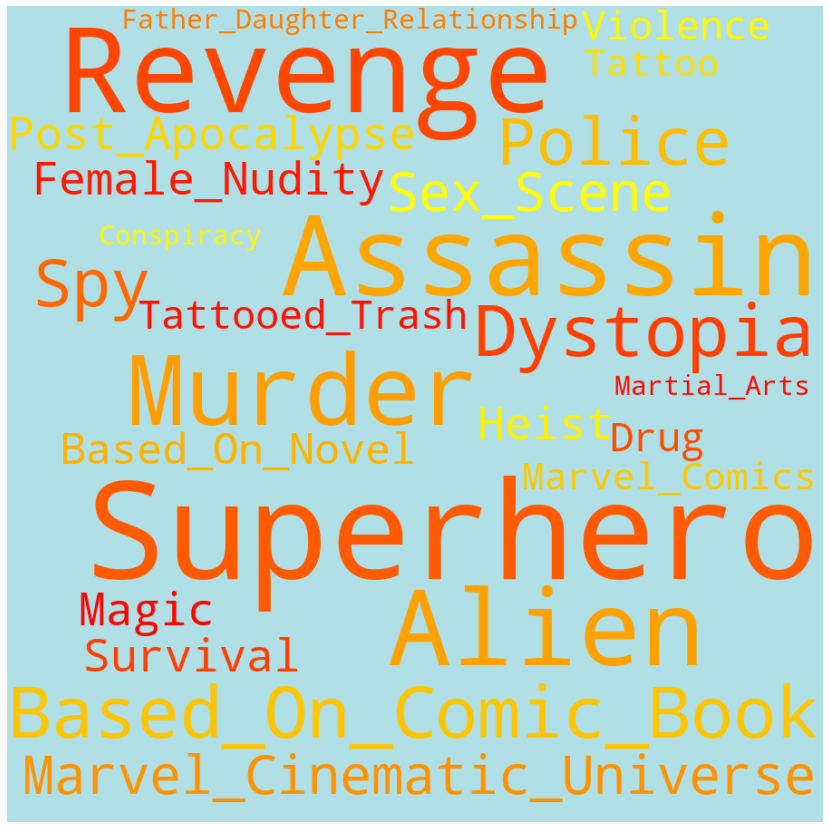

In [2203]:
#create the wordcloud object
plt.figure(figsize=(15,15))
action_wordcloud = WordCloud(width = 900, height = 900, max_words=25, background_color = 'powderblue',
                      collocations=True, colormap = 'autumn', prefer_horizontal = 1, max_font_size = 150).generate(action_tt)

#plot the wordcloud object
plt.imshow(action_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

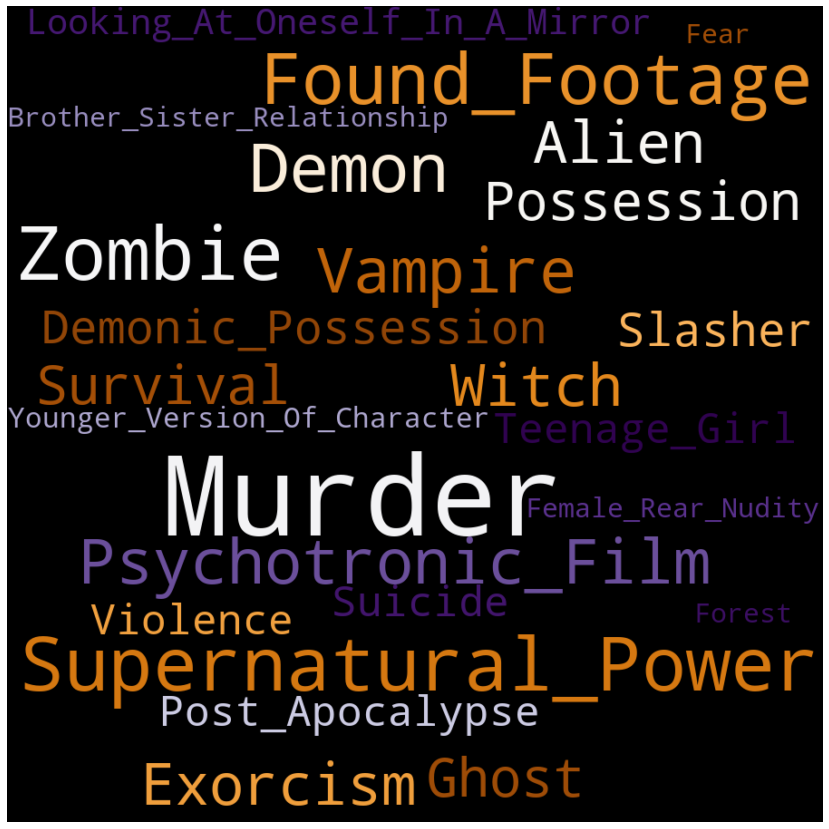

In [2038]:
#create the wordcloud object
plt.figure(figsize=(15,15))
horror_wordcloud = WordCloud(width = 900, height = 900, max_words=25, background_color = 'black',
                      collocations=True, colormap = 'PuOr', prefer_horizontal = 1).generate(horror_tt)

#plot the wordcloud object
plt.imshow(horror_wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

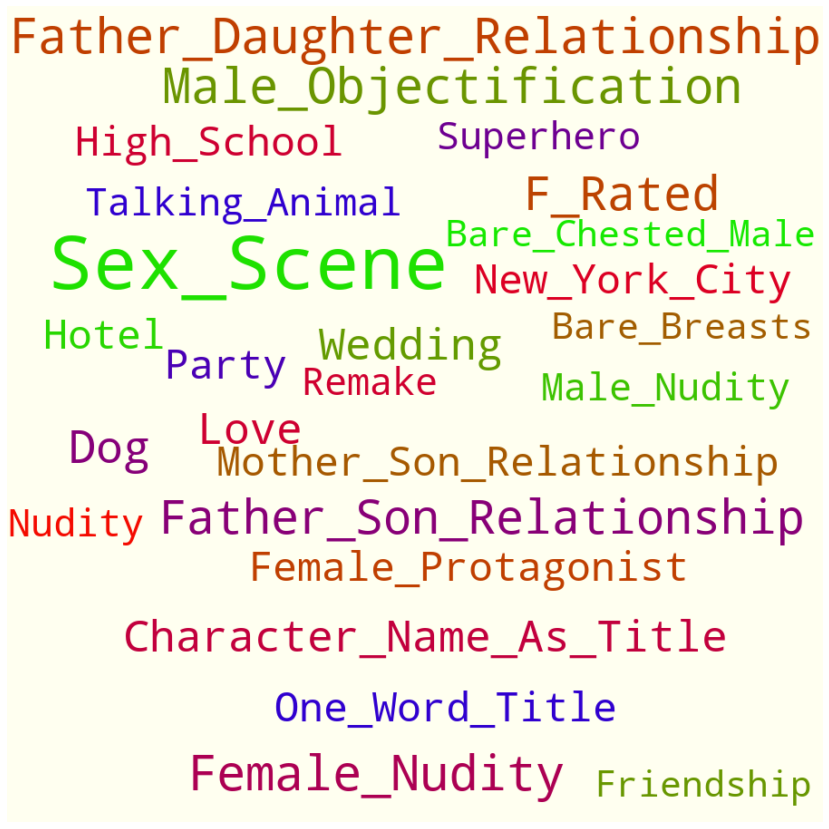

In [2036]:
#create the wordcloud object
plt.figure(figsize=(15,15))
comedy_wordcloud = WordCloud(width = 900, height = 900, max_words=25, background_color = 'ivory',
                      collocations=True, colormap = 'brg', prefer_horizontal = 1 ).generate(comedy_tt)

#plot the wordcloud object
plt.imshow(comedy_wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

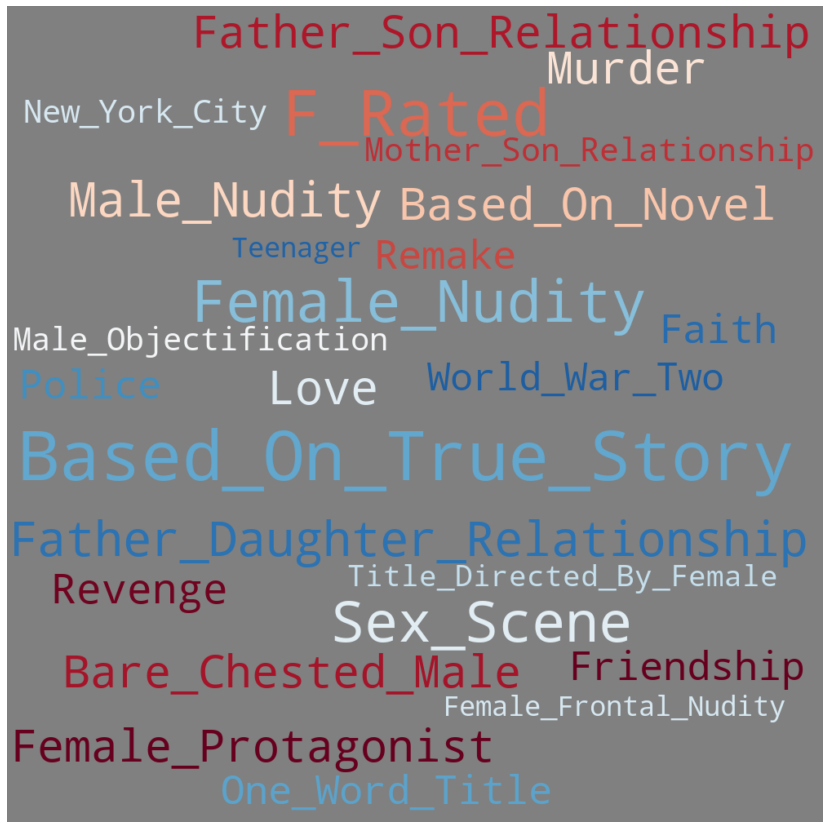

In [2005]:
#create the wordcloud object
plt.figure(figsize=(15,15))
drama_wordcloud = WordCloud(width = 1000, height = 1000, max_words=25, background_color = 'gray',
                      collocations=True, colormap = 'RdBu_r', prefer_horizontal = 1, stopwords = STOPWORDS).generate(drama_tt)

#plot the wordcloud object
plt.imshow(drama_wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

# Histograms of runtimes for the successful movies in each genre

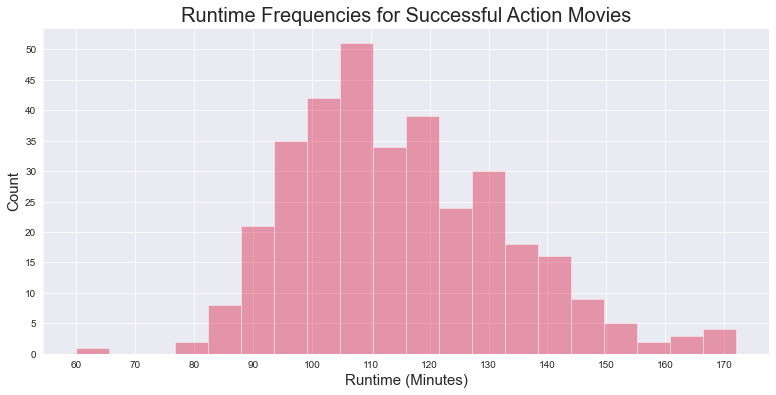

In [1910]:
sns.set_style('darkgrid')


actionfighist,actionaxhist = plt.subplots(figsize=(13,6))
sns.distplot(successful_action['runtime_minutes'], kde=False, bins = 20, color='crimson');
actionaxhist.set_xlabel('Runtime (Minutes)', fontsize=15)
actionaxhist.set_ylabel('Count', fontsize=15)
actionaxhist.set_title(f'Runtime Frequencies for Successful Action Movies', fontsize = 20)
plt.locator_params(axis='y', nbins = 15 )
plt.locator_params(axis='x', nbins = 20 )

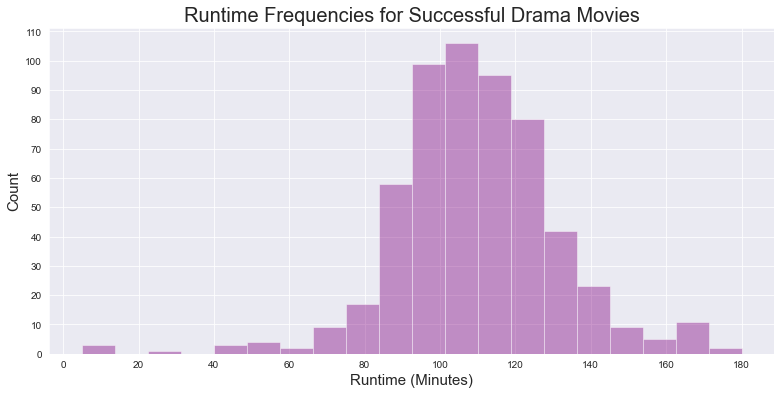

In [1909]:
dramafighist,dramaaxhist = plt.subplots(figsize=(13,6))
sns.distplot(successful_drama['runtime_minutes'], kde=False, bins = 20, color='purple');
dramaaxhist.set_xlabel('Runtime (Minutes)', fontsize=15)
dramaaxhist.set_ylabel('Count', fontsize=15)
dramaaxhist.set_title(f'Runtime Frequencies for Successful Drama Movies', fontsize = 20)
plt.locator_params(axis='x', nbins = 15 )
plt.locator_params(axis='y', nbins = 20 )

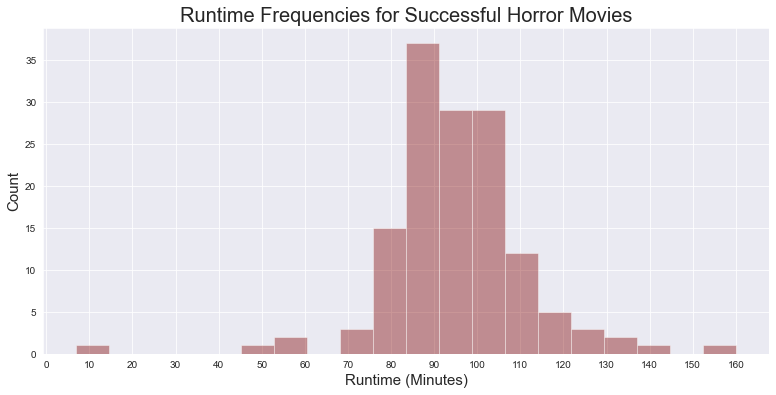

In [1802]:
horrorfighist,horroraxhist = plt.subplots(figsize=(13,6))
sns.distplot(successful_horror['runtime_minutes'], kde=False, bins = 20, color='maroon');
horroraxhist.set_xlabel('Runtime (Minutes)', fontsize=15)
horroraxhist.set_ylabel('Count', fontsize=15)
horroraxhist.set_title(f'Runtime Frequencies for Successful Horror Movies', fontsize = 20)
plt.locator_params(axis='y', nbins = 15 )
plt.locator_params(axis='x', nbins = 20)

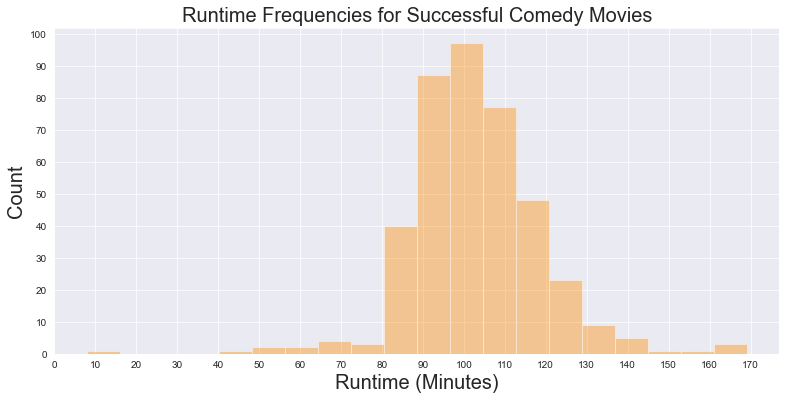

In [1908]:
comedyfighist,comedyaxhist = plt.subplots(figsize=(13,6))
sns.distplot(successful_comedy['runtime_minutes'], kde=False, bins = 20, color='darkorange');
comedyaxhist.set_xlabel('Runtime (Minutes)', fontsize=20)
comedyaxhist.set_ylabel('Count', fontsize=20)
comedyaxhist.set_title(f'Runtime Frequencies for Successful Comedy Movies', fontsize = 20)
plt.locator_params(axis='y', nbins = 15)
plt.locator_params(axis='x', nbins = 20 )

# Comparison of budget and profit

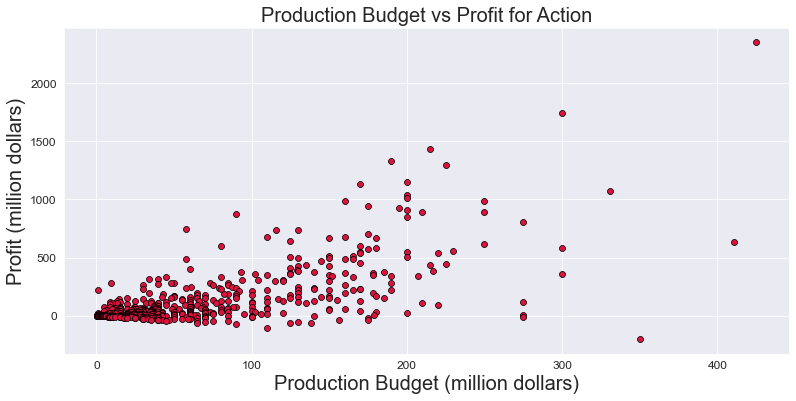

In [2065]:
actionfigscat, actionaxscat = plt.subplots(figsize = (13,6))
sns.scatterplot(x = (action_movies['production_budget']/1000000), y = (action_movies['total_profit']/1000000), color='crimson', edgecolor = 'black')
actionaxscat.set_xlabel('Production Budget (million dollars)', fontsize=20)
actionaxscat.set_ylabel('Profit (million dollars)', fontsize=20)
actionaxscat.set_title('Production Budget vs Profit for Action', fontsize = 20)
actionaxscat.tick_params(axis='x', labelsize= 12)
actionaxscat.tick_params(axis='y', labelsize= 12)

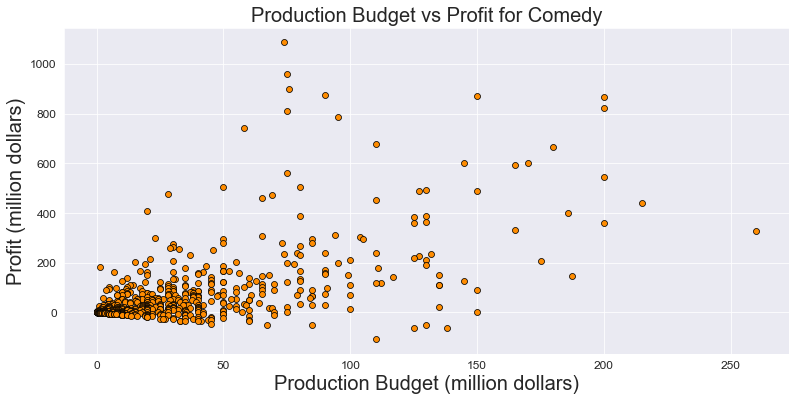

In [2469]:
comedyfigscat, comedyaxscat = plt.subplots(figsize = (13,6))
sns.scatterplot(x = (comedy_movies['production_budget']/1000000), y = (comedy_movies['total_profit']/1000000), color='darkorange', edgecolor = 'black')
comedyaxscat.set_xlabel('Production Budget (million dollars)', fontsize=20)
comedyaxscat.set_ylabel('Profit (million dollars)', fontsize=20)
comedyaxscat.set_title('Production Budget vs Profit for Comedy', fontsize = 20)
comedyaxscat.tick_params(axis='x', labelsize= 12)
comedyaxscat.tick_params(axis='y', labelsize= 12)

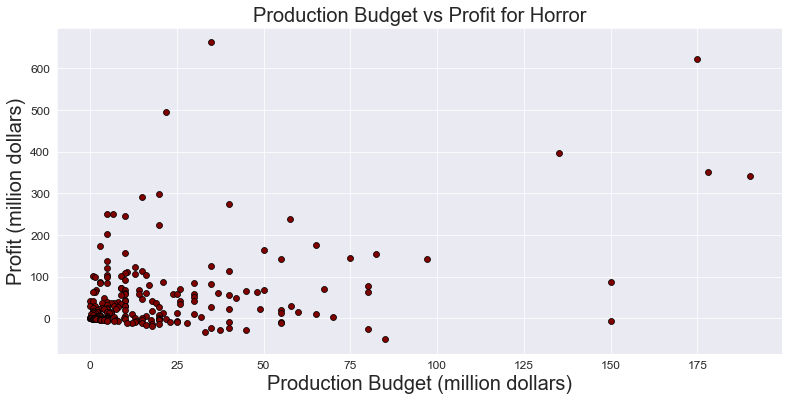

In [2067]:
horrorfigscat, horroraxscat = plt.subplots(figsize = (13,6))
sns.scatterplot(x = (horror_movies['production_budget']/1000000), y = (horror_movies['total_profit']/1000000), color='maroon', edgecolor = 'black')
horroraxscat.set_xlabel('Production Budget (million dollars)', fontsize=20)
horroraxscat.set_ylabel('Profit (million dollars)', fontsize=20)
horroraxscat.set_title('Production Budget vs Profit for Horror', fontsize = 20)
horroraxscat.tick_params(axis='x', labelsize= 12)
horroraxscat.tick_params(axis='y', labelsize= 12)

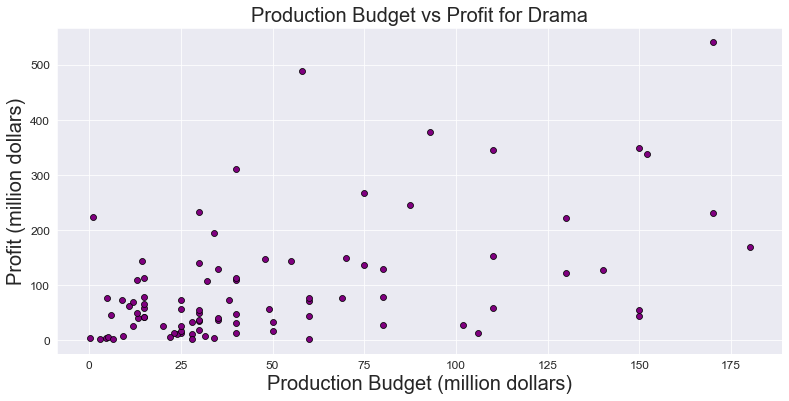

In [2068]:
dramafigscat, dramaaxscat = plt.subplots(figsize = (13,6))
sns.scatterplot(x = (successful_drama['production_budget']/1000000), y = (successful_action['total_profit']/1000000), color='purple', edgecolor = 'black')
dramaaxscat.set_xlabel('Production Budget (million dollars)', fontsize=20)
dramaaxscat.set_ylabel('Profit (million dollars)', fontsize=20)
dramaaxscat.set_title('Production Budget vs Profit for Drama', fontsize = 20)
dramaaxscat.tick_params(axis='x', labelsize= 12)
dramaaxscat.tick_params(axis='y', labelsize= 12)

# Added Rotten Tomatoes data to each genre's data frame for more analysis

In [1808]:
tomatoes_data = pd.read_csv('data/ZippedData/rotten_tomatoes_movies.csv.gz')

In [1809]:
def add_data(df):
    df_more_data = pd.merge(df, tomatoes_data, how='inner', left_on='primary_title', right_on='movie_title')
    return df_more_data

In [1810]:
successful_horror_moredata = add_data(successful_horror)
successful_comedy_moredata = add_data(successful_comedy)
successful_action_moredata = add_data(successful_action)
successful_drama_moredata = add_data(successful_drama)

### Dropped irrelevant columns and rows

In [1811]:
def drop_irrelevant_columns(df):
    columns_needed = ['primary_title', 'runtime_minutes', 'genres_x', 'release_date',
                       'production_budget', 'domestic_gross', 'worldwide_gross',
                       'total_profit', 'content_rating', 'directors', 'actors']
    return df[columns_needed]

In [1854]:
successful_action_moredata = drop_irrelevant_columns(successful_action_moredata)
successful_comedy_moredata = drop_irrelevant_columns(successful_comedy_moredata)
successful_drama_moredata = drop_irrelevant_columns(successful_drama_moredata)
successful_horror_moredata = drop_irrelevant_columns(successful_horror_moredata)

In [1870]:
successful_horror_moredata = successful_horror_moredata.drop(labels=2, axis=0)

## This function gets the content rating and the average profit earnings for each genre
### It then displays the results on a bar graph

In [1855]:
def get_rating_and_profit(data):
    return data.groupby(['content_rating']).mean()['total_profit']

In [1918]:
randp_action = get_rating_and_profit(successful_action_moredata).sort_values()
randp_comedy = get_rating_and_profit(successful_comedy_moredata).sort_values()
randp_drama = get_rating_and_profit(successful_drama_moredata).sort_values()
randp_horror = get_rating_and_profit(successful_horror_moredata).sort_values()

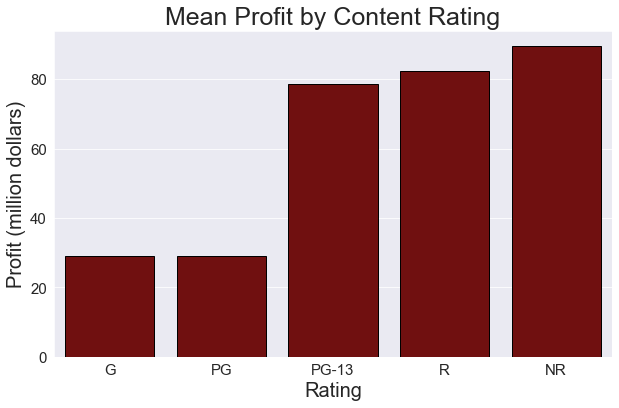

In [2394]:
horror_cr_fig, horror_cr_ax = plt.subplots(figsize = (10,6))
sns.barplot(x = randp_horror.index, y = randp_horror/1000000, color = 'maroon', edgecolor='black');
horror_cr_ax.set_xlabel('Rating', fontsize=20)
horror_cr_ax.set_ylabel('Profit (million dollars)', fontsize=20)
horror_cr_ax.set_title(f'Mean Profit by Content Rating', fontsize = 25)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15);

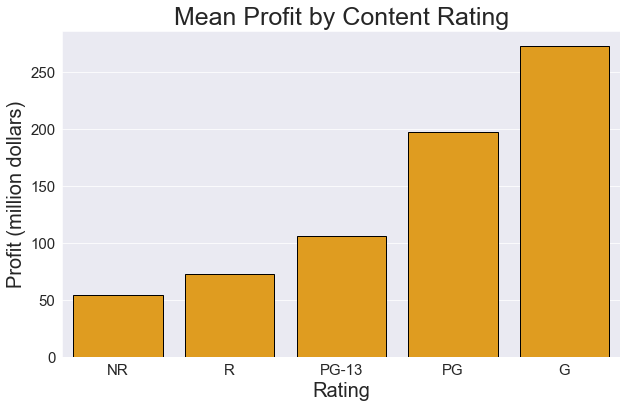

In [2393]:
comedy_cr_fig, comedy_cr_ax = plt.subplots(figsize = (10,6))
sns.barplot(x = randp_comedy.index, y = randp_comedy/1000000, color = 'orange', edgecolor='black');
comedy_cr_ax.set_xlabel('Rating', fontsize=20)
comedy_cr_ax.set_ylabel('Profit (million dollars)', fontsize=20)
comedy_cr_ax.set_title(f'Mean Profit by Content Rating', fontsize = 25)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15);

### This function gets the directors and their profit earnings for each genre

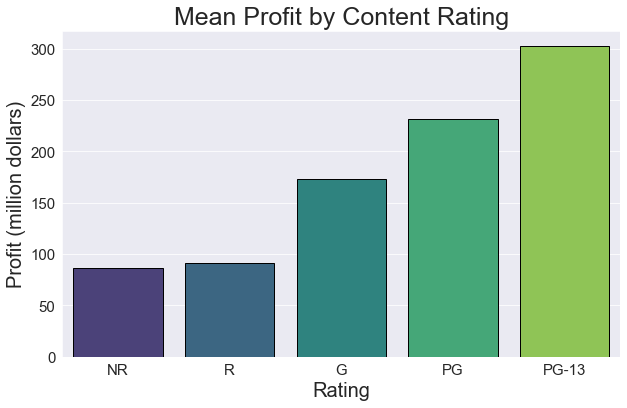

In [2468]:
action_cr_fig, action_cr_ax = plt.subplots(figsize = (10,6))
sns.barplot(x = randp_action.index, y = randp_action/1000000, color = 'crimson', edgecolor='black', palette = 'viridis');
action_cr_ax.set_xlabel('Rating', fontsize=20)
action_cr_ax.set_ylabel('Profit (million dollars)', fontsize=20)
action_cr_ax.set_title(f'Mean Profit by Content Rating', fontsize = 25)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15);

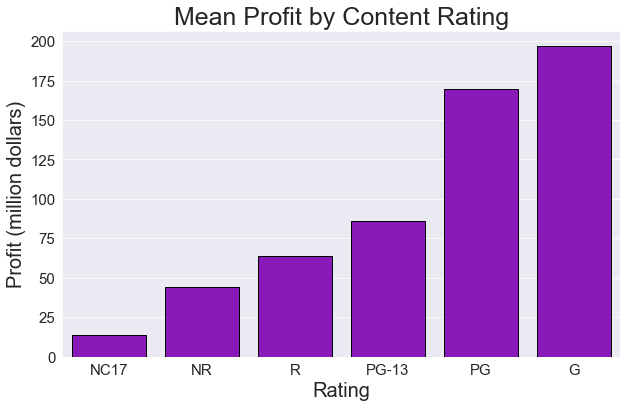

In [2396]:
drama_cr_fig, drama_cr_ax = plt.subplots(figsize = (10,6))
sns.barplot(x = randp_drama.index, y = randp_drama/1000000, color = 'darkviolet', edgecolor='black');
drama_cr_ax.set_xlabel('Rating', fontsize=20)
drama_cr_ax.set_ylabel('Profit (million dollars)', fontsize=20)
drama_cr_ax.set_title(f'Mean Profit by Content Rating', fontsize = 25)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15);

In [2044]:
# def director_profit(data):
#     return data.groupby(['directors']).mean()['total_profit']

In [2045]:
# dandp_action = director_profit(successful_action_moredata).sort_values(ascending=False)
# dandp_comedy = director_profit(successful_comedy_moredata).sort_values(ascending=False)
# dandp_drama = director_profit(successful_drama_moredata).sort_values(ascending=False)
# dandp_horror = director_profit(successful_horror_moredata).sort_values(ascending=False)
# dandp_action

In [2043]:
# def format_xaxis(data):
#     newlist = []
#     for element in list(data.index[:5]):
#         if ',' in element:
#             x = element.split(',')
#             if len(x) > 1:
#                 y = '\n'.join(x)
#                 newlist.append(y)
#             else:
#                 newlist.append(x)
#         else:
#              newlist.append(element)
#     return newlist

In [2243]:
for item in list_of_all_actors:
    if type(item) == float:
        pass
    else:
        item.split(",")

In [2244]:
actual_list_of_all_actors = []
for row in list_of_all_actors:
    if type(row) == float:
        pass
    else:
        for name in row.split(","):
            actual_list_of_all_actors.append(name)

In [2248]:
def get_unique_people(raw_people):
    all_people = []
    for person in raw_people:
                all_people.append(person)
    unique_people = set(all_people)
    unique_people = [(person.strip()) for person in unique_people]
    unique_people = set(unique_people)
    unique_people = list(unique_people)
    return unique_people

In [2249]:
unique_actors = get_unique_people(actual_list_of_all_actors)

In [2267]:
successful_action_moredata.dropna(subset=["total_profit"], inplace=True)
successful_action_moredata.dropna(subset=["actors"], inplace=True)
successful_action_moredata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383 entries, 0 to 383
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   primary_title      383 non-null    object 
 1   runtime_minutes    363 non-null    float64
 2   genres_x           383 non-null    object 
 3   release_date       383 non-null    object 
 4   production_budget  383 non-null    int64  
 5   domestic_gross     383 non-null    int64  
 6   worldwide_gross    383 non-null    int64  
 7   total_profit       383 non-null    int64  
 8   content_rating     383 non-null    object 
 9   directors          375 non-null    object 
 10  actors             383 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 35.9+ KB


In [2397]:
successful_action_moredata[successful_action_moredata["actors"].isna()]

,primary_title,runtime_minutes,genres_x,release_date,production_budget,domestic_gross,worldwide_gross,total_profit,content_rating,directors,actors


In [2398]:
def groupby_unformatted_column(df, unique, unique_category, aggregate_category):
    #unique is a list of unique values of the unique category
    return_list = []
    occurances_list = []
    label_list = []
    return_dict = {}
    for item in unique:
        frame = df[df[unique_category].str.contains(item)]
        aggregate = round(frame[aggregate_category].mean(), 1)
        occurance = len(frame[aggregate_category])
        occurances_list.append(occurance)
        return_list.append(aggregate)
    return_dict = {unique_category: list(unique), aggregate_category: return_list, "occurances": occurances_list}
    df = pd.DataFrame(return_dict)
    df["labels"] = df[unique_category].astype(str) + " (" + df["occurances"].astype(str) + ")"
    df.sort_values(aggregate_category, inplace=True, ascending = False)
    return df

In [2399]:
actors_mean_profit = groupby_unformatted_column(successful_action_moredata, unique_actors, "actors", "total_profit")

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [2400]:
actors_mean_profit.sort_values("total_profit", ascending=False, inplace=True)
actors_mean_profit = actors_mean_profit[actors_mean_profit["occurances"]>2]
actors_mean_profit

,actors,total_profit,occurances,labels
5525,Chadwick Boseman,1.262154e+09,3,Chadwick Boseman (3)
2774,Kerry Condon,1.114457e+09,3,Kerry Condon (3)
2194,Florence Kasumba,1.114399e+09,4,Florence Kasumba (4)
3008,Karen Gillan,1.074499e+09,3,Karen Gillan (3)
2986,Letitia Wright,9.861260e+08,3,Letitia Wright (3)
...,...,...,...,...
1343,Hannah Ware,2.311081e+07,3,Hannah Ware (3)
11453,Stuart Greer,2.194593e+07,3,Stuart Greer (3)
907,Emily Browning,2.021762e+07,3,Emily Browning (3)
2419,Keith David,1.631380e+07,3,Keith David (3)


In [2407]:
unwanted_actors = ["Ray","King", "Jr.", "Samuel L", "III"]

In [2408]:
drop_index = actors_mean_profit[actors_mean_profit["actors"].isin(unwanted_actors)].index

In [2409]:
actors_mean_profit.drop(drop_index, axis=0, inplace=True)

In [2410]:
actors_mean_profit.head()

,actors,total_profit,occurances,labels
5525,Chadwick Boseman,1.262154e+09,3,Chadwick Boseman (3)
2774,Kerry Condon,1.114457e+09,3,Kerry Condon (3)
2194,Florence Kasumba,1.114399e+09,4,Florence Kasumba (4)
3008,Karen Gillan,1.074499e+09,3,Karen Gillan (3)
2986,Letitia Wright,9.861260e+08,3,Letitia Wright (3)


In [2411]:
actors_occurances = actors_mean_profit.sort_values("occurances", ascending=False)

In [2471]:
top_actors_occurances = actors_occurances[0:11]
top_actors_occurances = top_actors_occurances.drop(9289)

In [2472]:
top_actors_profits = actors_mean_profit[0:11]
top_actors_profits = top_actors_profits.drop(5525)
top_actors_profits

,actors,total_profit,occurances,labels
2774,Kerry Condon,1.114457e+09,3,Kerry Condon (3)
2194,Florence Kasumba,1.114399e+09,4,Florence Kasumba (4)
3008,Karen Gillan,1.074499e+09,3,Karen Gillan (3)
2986,Letitia Wright,9.861260e+08,3,Letitia Wright (3)
6351,"Chris ""Ludacris"" Bridges",9.395775e+08,3,"Chris ""Ludacris"" Bridges (3)"
302,Mark Ruffalo,9.314633e+08,4,Mark Ruffalo (4)
363,William Hurt,9.168875e+08,3,William Hurt (3)
6247,Robert Downey Jr.,8.989994e+08,7,Robert Downey Jr. (7)
8707,Paul Rudd,8.800517e+08,4,Paul Rudd (4)
11142,Chris Pratt,8.764285e+08,6,Chris Pratt (6)


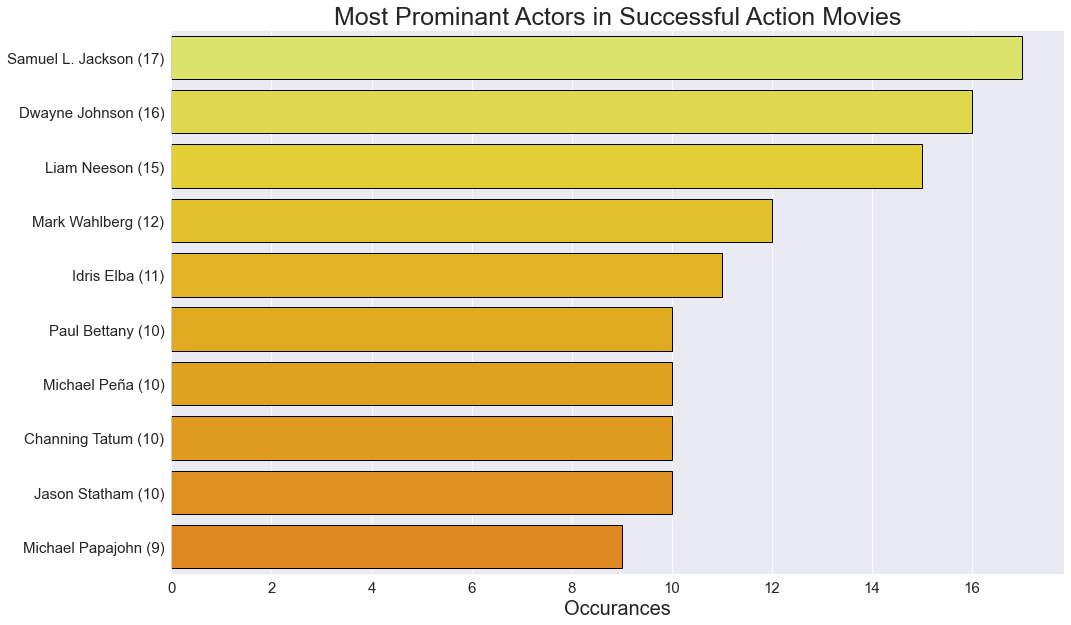

In [2473]:
fig, ax = plt.subplots(figsize = (16, 10))
actors_occur = sns.barplot(top_actors_occurances["occurances"], top_actors_occurances["labels"], edgecolor = 'black', palette = 'Wistia')
actors_occur.set(title="Successful Movie Actors");
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15);
ax.set_xlabel('Occurances', fontsize=20)
ax.set_ylabel('', fontsize=20)
ax.set_title('Most Prominant Actors in Successful Action Movies', fontsize = 25);

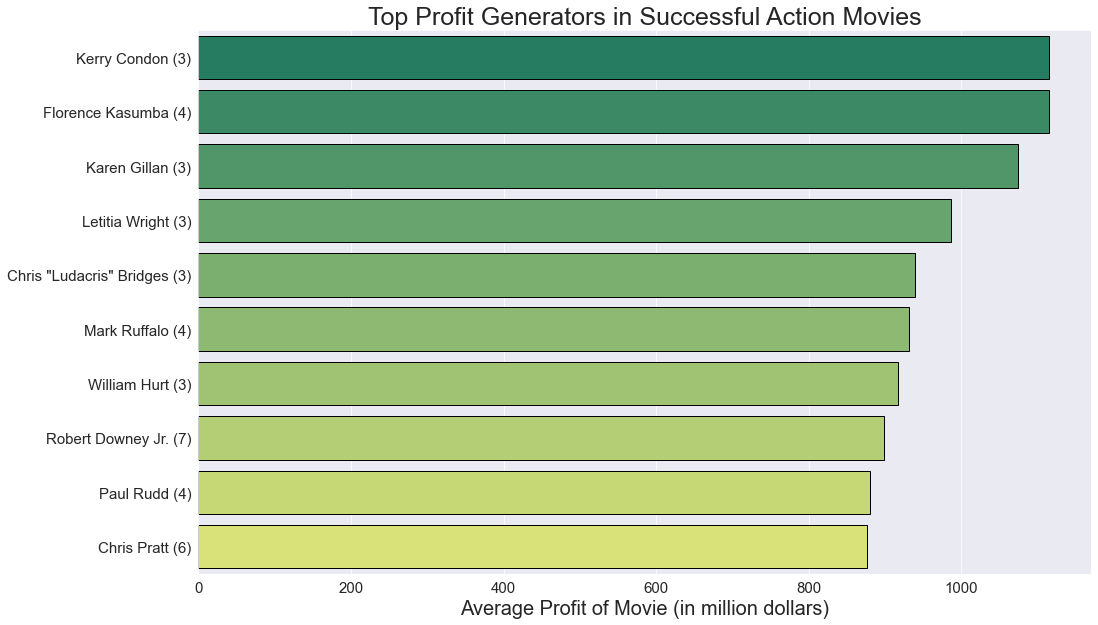

In [2476]:
fig, ax = plt.subplots(figsize = (16, 10))
actors_profits = sns.barplot(top_actors_profits["total_profit"]/1000000, top_actors_profits["labels"], edgecolor = 'black', palette = 'summer')
actors_profits.set(title="actors sorted by ammount of times they occur in successful action movies");
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15);
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('Average Profit of Movie (in million dollars)', fontsize=20);
ax.set_title(f'Top Profit Generators in Successful Action Movies', fontsize = 25);